In [2]:
from baselines.common import plot_util as pu
import matplotlib.pyplot as plt
import numpy as np

Logging to /tmp/openai-2018-11-19-20-20-31-582967


/home/agopal/Projects/Baselines/baselines/baselines/bench/monitor.py:164: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


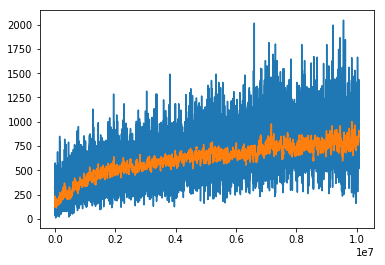

In [3]:

results = pu.load_results('~/Projects/ATLAS_S3_RL/logs/si_10M_ppo2')
r = results[0]
plt.plot(np.cumsum(r.monitor.l), r.monitor.r)
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=10))


AttributeError: 'DataFrame' object has no attribute 'eprewmean'

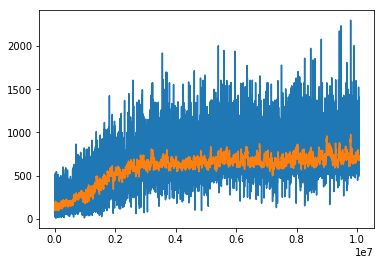

In [9]:
results2 = pu.load_results('~/Projects/ATLAS_S3_RL/logs/si_10M_acktr')
r2 = results2[0]
plt.plot(np.cumsum(r2.monitor.l), r2.monitor.r)
plt.plot(np.cumsum(r2.monitor.l), pu.smooth(r2.monitor.r, radius=10))
plt.plot(r2.progress.total_timesteps, r2.progress.eprewmean)

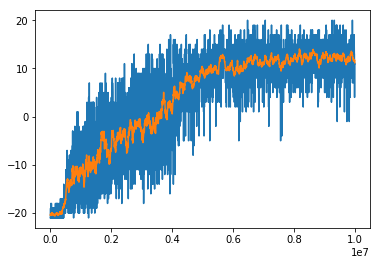

In [5]:
results3 = pu.load_results('~/Projects/ATLAS_S3_RL/logs/pong_10M_ppo2')
r3 = results3[0]
plt.plot(np.cumsum(r3.monitor.l), r3.monitor.r)
plt.plot(np.cumsum(r3.monitor.l), pu.smooth(r3.monitor.r, radius=10))

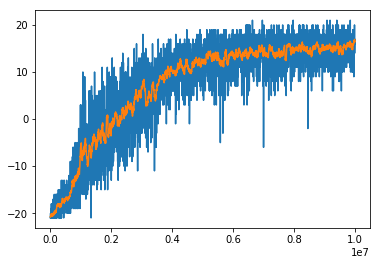

In [6]:
results4 = pu.load_results('~/Projects/ATLAS_S3_RL/logs/si-pong_10M_ppo2')
r4 = results4[0]
plt.plot(np.cumsum(r4.monitor.l), r4.monitor.r)
plt.plot(np.cumsum(r4.monitor.l), pu.smooth(r4.monitor.r, radius=10))

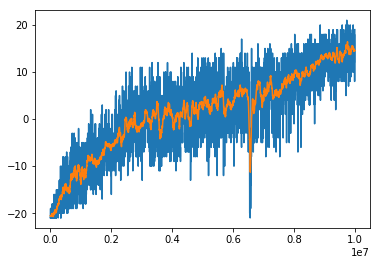

In [8]:
results5 = pu.load_results('~/Projects/ATLAS_S3_RL/logs/si-pong_10M_acktr')
r5 = results5[0]
plt.plot(np.cumsum(r5.monitor.l), r5.monitor.r)
plt.plot(np.cumsum(r5.monitor.l), pu.smooth(r5.monitor.r, radius=10))